# Assignment: Machine learning for Biology
students:
- Samar
    - Student number:
- Lars de Groot
    - Student number:

In [1]:
# ONLY RUN THIS CEL IN GOOGLE COLAB


In [2]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from pathlib import Path
from os.path import abspath

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input

from scikeras.wrappers import KerasClassifier

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold
from sklearn.experimental import enable_halving_search_cv

from sklearn.model_selection import (
    train_test_split,
    cross_validate,
    cross_val_score,
    StratifiedKFold,
    RandomizedSearchCV,
    GridSearchCV,
    HalvingGridSearchCV
)

from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

from sklearn.experimental import enable_halving_search_cv

In [3]:
global_seed = 42

# Load Data & Preprocess

## Exercise 1:
Do some exploratory data analysis. Don’t just look globally, also look at these metrics by class (if applicable). There might be differences, after all: 
- How many missing data are there? 
- Are there other strange values in the data? 
- What is the proportion of classes in your data? 
- Are there genes (features) that are extremely highly correlated with each other? If so, how many?
- What is the maximum value in the data, and the minimum? 
- Which feature has the highest variance? 
- Finally, make a boxplot of the expression values of the 30 features with the highest variance in the dataset, ordered by this variance. 

I expect a short comment on/answer to all these questions and what you found in your notebook, as well as the requested boxplot.

In [4]:
home_path = Path(abspath(''))
train_data_path = home_path.joinpath('data/train_2025.csv')
test_data_path = home_path.joinpath('data/test_2025.csv')
test_answers_path = home_path.joinpath('data/answer_key_2025.csv')

In [5]:
X_dataframe = pd.read_csv(train_data_path)
test_X_dataframe = pd.read_csv(test_data_path)
test_y_dataframe = pd.read_csv(test_answers_path)

In [6]:
X_dataframe.head()

,Gene 1,Gene 2,Gene 3,Gene 4,Gene 5,Gene 6,Gene 7,Gene 8,Gene 9,Gene 10,...,Gene 1993,Gene 1994,Gene 1995,Gene 1996,Gene 1997,Gene 1998,Gene 1999,Gene 2000,Outcome,Id
0,4.0,107.0,135.0,15752.0,459.0,189.0,222.0,2258.0,2992.0,77.0,...,156.0,18368.0,318.0,89.0,307.0,82.0,227.0,302.0,3,3328
1,4.0,96.0,130.0,13704.0,486.0,244.0,298.0,NaN,1874.0,50.0,...,82.0,21033.0,375.0,NaN,426.0,91.0,232.0,116.0,1,2085
2,5.0,139.0,71.0,13866.0,326.0,418.0,402.0,2833.0,1821.0,64.0,...,122.0,13853.0,244.0,114.0,273.0,87.0,219.0,NaN,3,2455
3,3.0,135.0,47.0,14945.0,432.0,239.0,224.0,3020.0,2958.0,69.0,...,50.0,16328.0,289.0,NaN,NaN,98.0,244.0,312.0,3,2457
4,2.0,69.0,48.0,8758.0,337.0,214.0,358.0,NaN,3388.0,80.0,...,119.0,10714.0,557.0,99.0,206.0,107.0,136.0,364.0,1,3641


In [7]:
# Seperate features and target variable
target_name = 'Outcome'
labels = X_dataframe[target_name]
features = X_dataframe.drop([target_name, 'Id'], axis=1) 

test_labels = test_y_dataframe.drop('Id', axis=1)
test_features = test_X_dataframe.drop('Id', axis=1)

### Missing data & Strange values

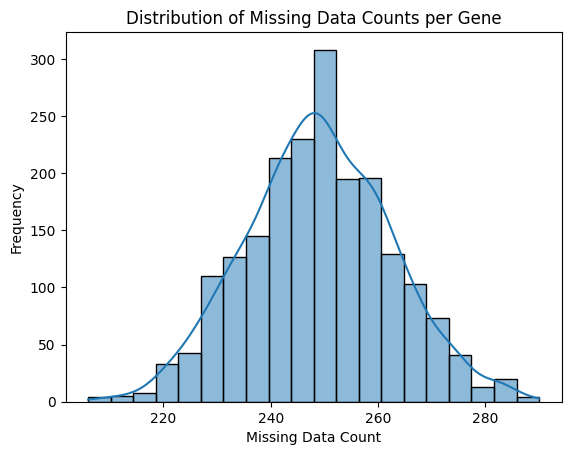

Total missing values across all features: 497869
This means that 7.07% of data points are missing

Total infinite values: 0
Total negative values: 0
Total 0.0 values: 1885


In [8]:
# Checking for missing values
missing_counts = features.isna().sum()

# Create a distribution plot
sns.histplot(missing_counts, kde=True, bins=20)
plt.xlabel('Missing Data Count')
plt.ylabel('Frequency')
plt.title('Distribution of Missing Data Counts per Gene')
plt.show()

print(f'Total missing values across all features: {missing_counts.sum()}')
print(f'This means that {round((missing_counts.sum() / (features.shape[0] * features.shape[1]) * 100), 2)}% of data points are missing')

print()

# Checking for strange values
num_infinite = np.isinf(features.values).sum()
num_negative = (features < 0).sum().sum()
num_zero = (features == 0.0).sum().sum()
print(f'Total infinite values: {num_infinite}')
print(f'Total negative values: {num_negative}')
print(f'Total 0.0 values: {num_zero}')

In the figure the distribution of missing data points per feature is plotted. We can see of all the features that have missing data points most are missing around 250 data points.

### Class proportion
The dataset can used to train a classifier to classify 4 subtypes of lung cancer. For classification it's important that the class distribution in the training data is as equal to the actual class distribution. Here we check how the different classes are distributed in the dataset

In [9]:
class_counts = labels.value_counts()
print('Class counts:')
print(class_counts)
print()
for i in range (4):
    print(f'The percentage of class {i} is {round((class_counts / class_counts.sum())[i]*100, 2)}%')

Class counts:
Outcome
3    1280
2     881
1     730
0     629
Name: count, dtype: int64

The percentage of class 0 is 17.87%
The percentage of class 1 is 20.74%
The percentage of class 2 is 25.03%
The percentage of class 3 is 36.36%


### Checking for multicollinearity
It’s highly likely that measured genes are correlated with each other. Groups of genes form systems together that enable cell 'behavior'; thus, groups of genes can have high or low expression together by being part of the same system. However, this correlation with each other is not favorable for a classifier because the expression of these correlated genes doesn’t hold extra information that can be used to discriminate samples from each other.

In [10]:
# checking for high correlation between features.
corr_matrix = features.corr().abs() # Might take a while
threshold = 0.95 
high_corr_pairs = []
all_correlations = []
cols = corr_matrix.columns

# count only unique pairs 
for i in range(len(cols)):
    for j in range(i + 1, len(cols)): # go across diagnal
        # Store all values for plot
        all_correlations.append(corr_matrix.iloc[i, j])
        if corr_matrix.iloc[i, j] > threshold:
            high_corr_pairs.append((cols[i], cols[j], corr_matrix.iloc[i, j]))

In [11]:
# Printing results
print(f'Number of gene pairs that exceed the corraltion threshold: {len(high_corr_pairs)}')

Number of gene pairs that exceed the corraltion threshold: 59


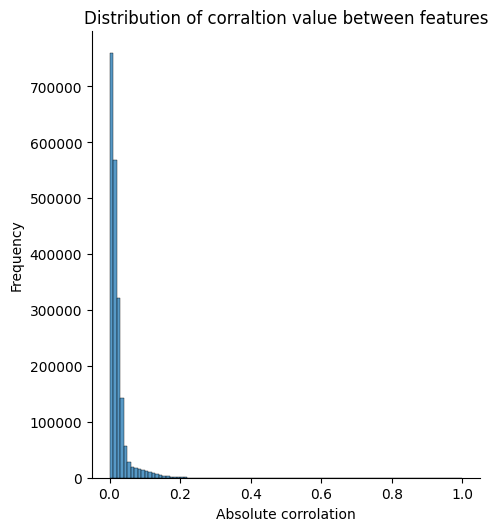

In [12]:
sns.displot(all_correlations, bins=100)
plt.xlabel('Absolute corrolation')
plt.ylabel('Frequency')
plt.title('Distribution of corraltion value between features')
plt.show()

Most gene pairs don't have high correlation with each other and after a correltion of about 0.2 there is a almost non existent tail of genes with a higher correlation. These genes might be of interest to exclude for our classificaton task.

### Data Range

In [13]:
print(f"Maximum value in the data: {features.max().max()}")
print(f"Minimum value in the data: {features.min().min()}")

Maximum value in the data: 51663.0
Minimum value in the data: 0.0


### Feature Variance

In [14]:
variances = features.var()
top_feature = variances.idxmax()
print(f'Feature with the highest variance: {top_feature}, with a variance value of: {round(variances.max(), 2)}')

Feature with the highest variance: Gene 1127, with a variance value of: 44663714.33


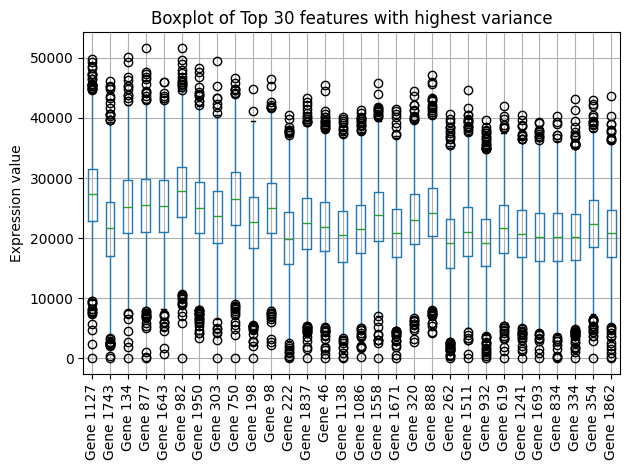

In [15]:
# boxplot of the top 30 features with highest variance.
top30_features = variances.sort_values(ascending=False).head(30).index

features[top30_features].boxplot(rot=90)
plt.title("Boxplot of Top 30 features with highest variance")
plt.ylabel("Expression value")
plt.tight_layout()
plt.show()

# Downsample data
2.	Big surprise: there’s missing data. Before you deal with that, take care of the class imbalance problem in the brute-force way described above: downsample the data so that you have equal numbers of data for each class. Continue with that training data to the following steps.

Clearly print the head and tail of the new training data (and labels) and show that it has equal amounts of each class.

In [16]:
from imblearn.under_sampling import RandomUnderSampler

sampled = RandomUnderSampler(random_state=42)
X_downSampled, y_downSampled = sampled.fit_resample(features, labels)

# Checking:
class_counts = y_downSampled.value_counts()
print('Class counts:')
print(class_counts)

Class counts:
Outcome
0    629
1    629
2    629
3    629
Name: count, dtype: int64


In [17]:
# Showing the head and tail of balanced downsampled data
display(X_downSampled.head(5))
display(X_downSampled.tail(5))
display(y_downSampled.head(5))
display(y_downSampled.tail(5))

,Gene 1,Gene 2,Gene 3,Gene 4,Gene 5,Gene 6,Gene 7,Gene 8,Gene 9,Gene 10,...,Gene 1991,Gene 1992,Gene 1993,Gene 1994,Gene 1995,Gene 1996,Gene 1997,Gene 1998,Gene 1999,Gene 2000
7,NaN,93.0,116.0,17932.0,409.0,249.0,278.0,2953.0,2021.0,69.0,...,7210.0,17690.0,86.0,14963.0,445.0,160.0,214.0,115.0,217.0,198.0
11,4.0,99.0,84.0,15956.0,452.0,296.0,407.0,3167.0,2169.0,39.0,...,3880.0,17901.0,123.0,17115.0,286.0,150.0,237.0,NaN,NaN,137.0
12,5.0,118.0,120.0,20132.0,538.0,405.0,290.0,2813.0,1739.0,34.0,...,NaN,20810.0,111.0,15853.0,391.0,105.0,290.0,67.0,259.0,302.0
15,5.0,79.0,82.0,11633.0,608.0,231.0,519.0,1756.0,1209.0,49.0,...,6561.0,21187.0,162.0,15585.0,439.0,94.0,259.0,124.0,115.0,163.0
17,5.0,125.0,54.0,NaN,313.0,276.0,369.0,2088.0,2759.0,54.0,...,11090.0,33076.0,99.0,14565.0,358.0,128.0,270.0,77.0,168.0,186.0


,Gene 1,Gene 2,Gene 3,Gene 4,Gene 5,Gene 6,Gene 7,Gene 8,Gene 9,Gene 10,...,Gene 1991,Gene 1992,Gene 1993,Gene 1994,Gene 1995,Gene 1996,Gene 1997,Gene 1998,Gene 1999,Gene 2000
2995,4.0,114.0,80.0,12000.0,NaN,435.0,398.0,2059.0,1345.0,89.0,...,11219.0,26282.0,139.0,NaN,396.0,128.0,254.0,67.0,NaN,271.0
2601,4.0,81.0,114.0,16504.0,298.0,243.0,536.0,2378.0,2293.0,48.0,...,9584.0,18903.0,96.0,15749.0,385.0,170.0,230.0,63.0,212.0,159.0
1310,5.0,101.0,55.0,16208.0,448.0,281.0,509.0,1169.0,2987.0,50.0,...,6066.0,17372.0,129.0,18914.0,352.0,110.0,385.0,73.0,153.0,254.0
2816,3.0,110.0,113.0,15376.0,310.0,253.0,306.0,2865.0,2861.0,64.0,...,9424.0,21083.0,84.0,19860.0,329.0,236.0,208.0,63.0,NaN,108.0
1372,4.0,152.0,96.0,14202.0,166.0,258.0,326.0,2222.0,1918.0,77.0,...,6554.0,23031.0,120.0,20175.0,535.0,109.0,394.0,73.0,180.0,239.0


7     0
11    0
12    0
15    0
17    0
Name: Outcome, dtype: int64

2995    3
2601    3
1310    3
2816    3
1372    3
Name: Outcome, dtype: int64

## 3, 4, 5 - Regression

### 3 - Simple imputation, Standard Scaling, and non-regularized Logistic regression

Make a Pipeline that combines three steps: 
* imputing missing data (removing np.nan) by replacing them with the mean value (SimpleImputer) ✅
* scaling the data to have 0 mean and unit variance (StandardScaler) ✅
* predicting the class using unregularized logistic regression (sklearn.linear_model.LogisticRegression) ✅

Now
* split the training data into 20% validation and 80% train data. ✅
* Fit the Pipeline on the train data and test on the validation data. ✅

In your notebook file:
* report the ROC AUC one-versus-rest and macro F1 score on the training and validation data. ✅
* Read up on these here (1, 2) so you know what they are, and write what they do in your own words in the notebook. ✅
* describe why you can’t directly impute and/or scale on all the training data and only then split into train and validation sets if you want an accurate estimate of your generalisation performance ✅

In [18]:
# Split the data into train and validation datasets (both data and labels)
train_data_3, val_data_3, train_lables_3, val_lables_3 = train_test_split(X_downSampled, y_downSampled, train_size=0.8, random_state=global_seed)

# Build the pipeline for our model
imputer_3 = SimpleImputer(missing_values=np.nan, strategy='mean')
scaler_3 = StandardScaler()
log_regressor_3 = LogisticRegression(penalty=None)

model_3 = make_pipeline(imputer_3, scaler_3, log_regressor_3)

# train model
start = time.time()
model_3.fit(train_data_3, train_lables_3)
print(f"Fitting took {time.time() - start:0.03} seconds")

# validate model - get the accuracy on the validation dataset
accuracy_3 = model_3.score(val_data_3, val_lables_3)
print(f"Accuracy of model on validation dataset: {accuracy_3:0.03}")

Fitting took 0.163 seconds
Accuracy of model on validation dataset: 0.631


**The reason we can't can’t directly impute and/or scale on all the training data and only then split into train and validation sets if we want an accurate estimate of your generalisation performance**

If we first impute and/or scale our data and only then split it into training and validation, we are introducing into our model some information about the validation data which is supposed to be unseen data. This data leakage would influence the pipeline and lead to more optimistic results on the validation dataset, but we wouldn't be able to know how our model generalizes on truly unseen data.

In [19]:
# Reporting the Macro F1 and the ROC AUC OvR scores for our trained model

# Training
# We use the predict_proba and not predict, since for ROC (and AUC) we need to predict for different thresholds
train_3_OvR_AUC = roc_auc_score(train_lables_3, model_3.predict_proba(train_data_3), multi_class='ovr')
train_3_macro_F1 = f1_score(train_lables_3, model_3.predict(train_data_3), average='macro')
print(f"Our model's scores on the training dataset:")
print(f"OvR AUC score: {train_3_OvR_AUC:0.03}\nMacro F1 score: {train_3_macro_F1:0.03}\n")

# Validation
val_3_OvR_AUC = roc_auc_score(val_lables_3, model_3.predict_proba(val_data_3), multi_class='ovr')
val_3_macro_F1 = f1_score(val_lables_3, model_3.predict(val_data_3), average='macro')
print(f"Our model's scores on the validation dataset:")
print(f"OvR AUC score: {val_3_OvR_AUC:0.03}\nMacro F1 score: {val_3_macro_F1:0.03}\n")

Our model's scores on the training dataset:
OvR AUC score: 1.0
Macro F1 score: 1.0

Our model's scores on the validation dataset:
OvR AUC score: 0.866
Macro F1 score: 0.63



**What are ROC AUC one-versus-rest and macro F1 score?**

_ROC AUC one-versus-rest (OvR):_

OvR is A method to used binary-class-metrics to evaluate multiclass models. In this method, we iterate on our classification output n times, each time taking the n-th class as "Positive" and all other classes as "Negative". This enable us to treat each of these iterations as a binary classification. We then get the results of all metrics on each of these iterations, and average them to get the final OvR model scores.

For ROC AUC one-versus-rest we plot an ROC curve and calculate the AUC for every iteration of OvR, and return the final average score of AUC.

_macro F1 score:_

F1 is a metric that combines both precision and recall. For multi-class classification, we calculate F1 score using OvR. To combine the scores into one final score, there are different methods, one of which is Macro Average.

With Macro Average, we take the unweighted mean of the F1 scores per class (OvR). This gives a similar weight to all classes, even for an imbalanced data.

### 4 - KNN imputation, Standard Scaling, and non-regularized Logistic regression

Again, make a Pipeline that combines three steps:
* scaling each value to 0 mean and unit variance ✅
* using a KNN imputer to impute missing data (removing np.nan). Set n_neighbors to 3 and weights to ‘distance’. Make sure you understand what this does. ✅
* Using a logistic regression without regularisation to predict the class. ✅
* Train on the same 80% split ✅
* report the performance on the validation data (F1 macro; ROC AUC OvR). ✅
* Then finally train on all your training data, and predict on the test set. ❌❌❌❌ (**Dieter removed this**)
* In your notebook, write down why the order of imputation and scaling is now different compared to step 3, and what would happen if you do it the other way around. ✅


In [20]:
# Build the pipeline for our model
imputer_4 = KNNImputer(missing_values=np.nan, n_neighbors=3, weights='distance')
scaler_4 = StandardScaler()
log_regressor_4 = LogisticRegression(penalty=None)

model_4 = make_pipeline(scaler_4, imputer_4, log_regressor_4)

# train model
start = time.time()
model_4.fit(train_data_3, train_lables_3)
print(f"Fitting took {time.time() - start:0.03} seconds")

# validate model - get the accuracy on the validation dataset
accuracy_4 = model_4.score(val_data_3, val_lables_3)
print(f"Accuracy of model on validation dataset: {accuracy_4:0.03}")

Fitting took 19.3 seconds
Accuracy of model on validation dataset: 0.643


We can see that using KNN imputation takes a lot longer than the simple impute (193 seconds vs. 0.505 seconds).

In [21]:
# Reporting the Macro F1 and the ROC AUC OvR scores for our trained model

# Training
start = time.time()
# We use the predict_proba and not predict, since for ROC (and AUC) we need to predict for different thresholds
train_4_OvR_AUC = roc_auc_score(train_lables_3, model_4.predict_proba(train_data_3), multi_class='ovr')
train_4_macro_F1 = f1_score(train_lables_3, model_4.predict(train_data_3), average='macro')
print(f"Our model's scores on the training dataset:")
print(f"OvR AUC score: {train_4_OvR_AUC:0.03}\nMacro F1 score: {train_4_macro_F1:0.03}")
print(f"Getting score took {time.time() - start:0.03} seconds\n")

# Validation
start = time.time()
val_4_OvR_AUC = roc_auc_score(val_lables_3, model_4.predict_proba(val_data_3), multi_class='ovr')
val_4_macro_F1 = f1_score(val_lables_3, model_4.predict(val_data_3), average='macro')
print(f"Our model's scores on the validation dataset:")
print(f"OvR AUC score: {val_4_OvR_AUC:0.03}\nMacro F1 score: {val_4_macro_F1:0.03}\n")
print(f"Getting score took {time.time() - start:0.03} seconds")

Our model's scores on the training dataset:
OvR AUC score: 1.0
Macro F1 score: 1.0
Getting score took 37.3 seconds

Our model's scores on the validation dataset:
OvR AUC score: 0.877
Macro F1 score: 0.642

Getting score took 9.48 seconds


**Why the order of imputation and scaling is now different compared to step 3, and what would happen if we do it the other way around?**

The simple imputer we used in model 3 only uses the mean to impute the missing values.

In contrast, with KNN imputation we search of the n most similar rows to the row with the missing value. Then, it calculate the average (if weight='distance' then this is a weighted average where the weights are the inverse of the distance from our row to this neighbor), and assigns this as the missing value.

If the data is not scaled, then features with a larger range of values would have less effect on the neighbors chosen for KNN imputation than features with a smaller range. Less effect because we use weight that are the inverse of the distance, and a larger range of values would then on average give smaller weights.Therefore it's important to first scale the data.

If we first impute using KNN and only then scale, then some features will dominante over other in the imputation.

**Extra - comparing model with different imputations**

Model 3 scores on the validation dataset:
* OvR AUC score: 0.866
* Macro F1 score: 0.63

Model 4 scores on the validation dataset:
* OvR AUC score: 0.877
* Macro F1 score: 0.642

We can see that the model with KNN imputation performs slightly better than the one with the simple imputation. This makes sense, since KNN can take into account correlation between features and can learn from the structure of the data, and thus create a more realistic imputation.

However, KNN imputation does take a longer time hence we'll still be using the simple imputation.

### 5 - Simple imputation, and L2 regularized Logistic regression - with cross validation

Regularise using an L2 penalty with a C of one. Note that C is 1/λ. ✅

We will also use cross-validation now, as we know that this gives a better estimate of generalisation performance and uses training data more efficiently.

Make a new Pipeline that:
* uses the SimpleImputer again (KNN is slow) ✅
* uses L2-regularised logistic regression for classification ✅

For training the model:
* use 10-fold cross-validation rather than a single split. Use sklearn.model_selection.cross_validate ✅
* look at F1 macro and ROC AUC OvR averaged over the folds. ✅

Finally
* Report how much average cross-validation performance with regularisation included improves over unregularized logistic regression. ✅

In [22]:
# Build the pipeline for our model
imputer_5 = SimpleImputer(missing_values=np.nan, strategy='mean')
scaler_5 = StandardScaler()
log_regressor_5 = LogisticRegression(penalty='l2', C=1)

model_5 = make_pipeline(imputer_5, scaler_5, log_regressor_5)

# train model
start = time.time()
cv_result_5 = cross_validate(model_5, X_downSampled, y_downSampled, cv=10, scoring=['accuracy', 'f1_macro', 'roc_auc_ovr'])
print(f"Fitting took {time.time() - start:0.03} seconds")

Fitting took 3.99 seconds


In [23]:
# validate model:
# calculate the average scores for accuracy, Macro F1 and ROC AUC Ovr, across all folds
print(f"Average accuracy of model across folds: {np.mean(cv_result_5['test_accuracy']):0.03}")
print(f"Average Macro F1 score of model across folds: {np.mean(cv_result_5['test_f1_macro']):0.03}")
print(f"Average OvR AUC score of model across folds: {np.mean(cv_result_5['test_roc_auc_ovr']):0.03}")

Average accuracy of model across folds: 0.652
Average Macro F1 score of model across folds: 0.652
Average OvR AUC score of model across folds: 0.875


**Reporting how much average cross-validation performance with regularisation included improves over unregularized logistic regression**

When performing unregularized logistic regression without cross-validation (model 3) we got the following scores on the validation dataset:
* Accuracy: 0.631
* Macro F1: 0.63
* OvR AUC: 0.866

In comparsion, we can see that all scores improve when performing a cross validation with a regularized logistic regression and taking the average scores on all folds.

We can see that both accuracy and Macro F1 improved by ~13%, and OvR AUC improved by ~5% (using percent increase, calculations below).

In [24]:
accuracy_change = ((0.713-0.631)/0.631) * 100
macro_F1_change = ((0.713-0.63)/0.63) * 100
OvR_AUC_change = ((0.908-0.866)/0.866) * 100

print(f"accuracy_change: {accuracy_change:.2f}%\nmacro_F1_change: {macro_F1_change:.2f}%\nOvR_AUC_change: {OvR_AUC_change:.2f}%")

accuracy_change: 13.00%
macro_F1_change: 13.17%
OvR_AUC_change: 4.85%


## 6, 7, 8 - PCA

### 6 - PCA

* Do a PCA on your (normalised, imputed) training data (all of it, not within a Pipeline) ✅
* make a plot of the first 2 PCs. ✅
  * Colour the points by the class labels. ✅
* How much variance is on the first and second component? ✅
* Which single feature contributes the most to each PC? ✅


I want to see this plot and the answer to these two questions in your notebook ✅

In [25]:
# Preprocess data
imputer_scaler = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='mean'), 
                               StandardScaler())
imputer_scaler.fit(X_downSampled)
X_downSampled_scaled = imputer_scaler.transform(X_downSampled)

# Get PCs
pca = PCA()
X_pca = pca.fit_transform(X_downSampled_scaled)

/var/folders/d1/l_4p1glj58l0j48j_zdxnm1h0000gn/T/ipykernel_1543/3902970740.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


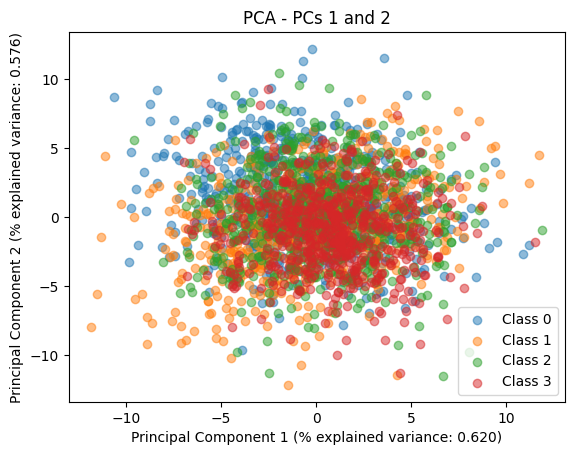

In [26]:
# Create PCA plot
fig, ax = plt.subplots()
plt.title('PCA - PCs 1 and 2')
plt.xlabel(f'Principal Component 1 (% explained variance: {pca.explained_variance_ratio_[0]*100:.3f})')
plt.ylabel(f'Principal Component 2 (% explained variance: {pca.explained_variance_ratio_[1]*100:.3f})')

for class_id in y_downSampled.unique():
    ix = np.where(y_downSampled == class_id)
    ax.scatter(x=X_pca[ix, 0], y=X_pca[ix, 1], label="Class "+str(class_id), alpha=0.5)

ax.legend()
fig.show()

**How much variance is on the first and second component?**

In [27]:
print(f"Variance explained by first 2 PCs: {sum(pca.explained_variance_ratio_[:2])*100:.3f}%")

Variance explained by first 2 PCs: 1.196%


**Which single feature contributes the most to each PC?**


In [28]:
pca_components = np.abs(pca.components_)

pca_feature_per_pc_df = pd.DataFrame(
    {"PC": [f"PC {i+1}" for i in range(pca_components.shape[0])], 
     "Most contributing feature": [X_downSampled.columns[i] for i in np.argmax(pca_components, axis=1)]}
)

pca_feature_per_pc_df  = pca_feature_per_pc_df.set_index("PC")

print("Showing which feature (gene) contributes the most to each of the PCs")
display(pca_feature_per_pc_df)

Showing which feature (gene) contributes the most to each of the PCs


,Most contributing feature
PC,
PC 1,Gene 618
PC 2,Gene 1521
PC 3,Gene 1564
PC 4,Gene 1920
PC 5,Gene 1806
...,...
PC 1996,Gene 1510
PC 1997,Gene 1693
PC 1998,Gene 506


**Extra - plotting the explained variance in % for all PCs**

/var/folders/d1/l_4p1glj58l0j48j_zdxnm1h0000gn/T/ipykernel_1543/3065823272.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


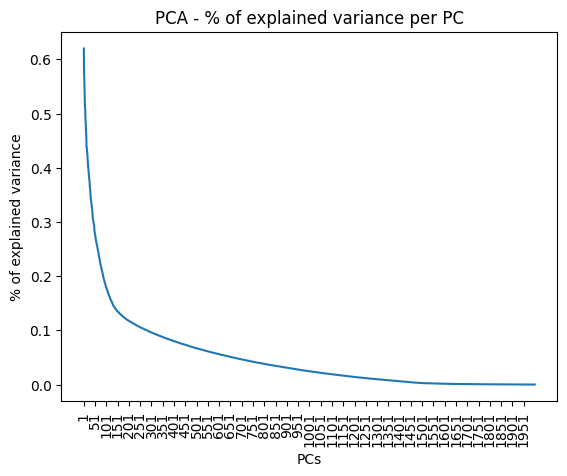

In [29]:
# Plot all explained variances per PC
explained_variance = pca.explained_variance_ratio_ * 100

fig, ax = plt.subplots()
plt.title(r'PCA - % of explained variance per PC')
plt.xlabel('PCs')
plt.ylabel(r'% of explained variance')

ax.plot(range(1, len(explained_variance) + 1), explained_variance)
plt.xticks(range(1, len(explained_variance) + 1, 50), rotation=90)

fig.show()

**Extra - find variance captured in more PCs**

In [30]:
print(f"Variance explained by first 100 PCs: {sum(pca.explained_variance_ratio_[:100])*100:.3f}%")

Variance explained by first 100 PCs: 30.834%


In [31]:
print(r"To capture 70% of the variance we need to take", np.where(pca.explained_variance_ratio_.cumsum() > 0.7)[0][0], "PCs")
print(r"To capture 80% of the variance we need to take", np.where(pca.explained_variance_ratio_.cumsum() > 0.8)[0][0], "PCs")
print(r"To capture 90% of the variance we need to take", np.where(pca.explained_variance_ratio_.cumsum() > 0.9)[0][0], "PCs")

print('\n** "To capture" meaning to capture at least this amount of variance')

To capture 70% of the variance we need to take 477 PCs
To capture 80% of the variance we need to take 642 PCs
To capture 90% of the variance we need to take 883 PCs

** "To capture" meaning to capture at least this amount of variance


**Extra - discussing the PCA results**

We can see that there is no small amount of features that capture a big precent of the variance. To capture at least 70% of the variance we need to take 477 PCs, 642 PCs for 80% of the variance and 883 PCs for 90% of the variance.

In part 7 we use 100 PCs in our model. We see that although this improve the performance of the model, the improvement is not great. This might be due to the fact that these 100 PCs only capture ~30% of the data, and hence this might not be enough to train our model.

### 7 - PCA inside a prediction pipeline

For the next part, let’s 
* use PCA in your prediction Pipeline. ✅
  * Insert a PCA step where you think it fits ✅
    * use 100 principal components. ✅
* Keep the regularisation in your logistic regression. ✅
* Report the average macro F1 score and ROC AUC OvR over folds now that you’ve included linear dimensionality reduction in your notebook. ✅
* How many percentage points do you improve? ✅
* Train a final model on all training data. Use this final model to predict on the test set. ❌❌❌❌ (**Dieter removed this**)

In [32]:
# Build the pipeline for our model
imputer_7 = SimpleImputer(missing_values=np.nan, strategy='mean')
scaler_7 = StandardScaler()
pca_7 = PCA(n_components=100)
log_regressor_7 = LogisticRegression(penalty='l2', C=1)

model_7 = make_pipeline(imputer_7, scaler_7, pca_7, log_regressor_7)

# train model
start = time.time()
cv_result_7 = cross_validate(model_7, X_downSampled, y_downSampled, cv=10, scoring=['accuracy', 'f1_macro', 'roc_auc_ovr'])
print(f"Fitting took {time.time() - start:0.03} seconds")

Fitting took 6.99 seconds


In [33]:
# validate model:
# calculate the average scores for accuracy, Macro F1 and ROC AUC Ovr, across all folds
print(f"Average accuracy of model across folds: {np.mean(cv_result_7['test_accuracy']):0.03}")
print(f"Average Macro F1 score of model across folds: {np.mean(cv_result_7['test_f1_macro']):0.03}")
print(f"Average OvR AUC score of model across folds: {np.mean(cv_result_7['test_roc_auc_ovr']):0.03}")

Average accuracy of model across folds: 0.669
Average Macro F1 score of model across folds: 0.669
Average OvR AUC score of model across folds: 0.886


**How many percentage points do you improve?**
(Comparing to model 5)

When adding PCA and taking the 100 PCs that explain the most variance, we can see that the model improves a bit. We see an improvement of ~3 percent points in accuracy and Macro F1 score, and an improvement of ~1 percent points in OvR AUC score.
(calculations below)

Although this is an improvement, this is not a big improvement. We saw in part 6 that these 100 PCs only capture ~30% of the variance in our data, which might be the reason why the model doesn't perform as well as we've hoped. Still, this small improvement suggests that we hopefully managed to reduce the noise in our data and helped our model generalize better.

In [34]:
# Compare the scored for model 5 (no PCA) and model 7 (includes PCA with choosing 
# 100 principal components)
accuracy_change = (np.mean(cv_result_7['test_accuracy'])-np.mean(cv_result_5['test_accuracy'])) * 100
macro_F1_change = (np.mean(cv_result_7['test_f1_macro'])-np.mean(cv_result_5['test_f1_macro'])) * 100
OvR_AUC_change = (np.mean(cv_result_7['test_roc_auc_ovr'])-np.mean(cv_result_5['test_roc_auc_ovr'])) * 100

print(f"accuracy_change: {accuracy_change:.2f} percent points\nmacro_F1_change: {macro_F1_change:.2f}%\nOvR_AUC_change: {OvR_AUC_change:.2f}%")

accuracy_change: 1.67 percent points
macro_F1_change: 1.71%
OvR_AUC_change: 1.04%


In [35]:
# Training a final model (model 7)
final_model_7 = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy='mean'), 
    StandardScaler(), 
    PCA(n_components=100), 
    LogisticRegression(penalty='l2', C=1)
)

final_model_7.fit(X=X_downSampled, y=y_downSampled)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=100)),
                ('logisticregression', LogisticRegression(C=1))])

### 8 - PCA with nested cross-validation

There’s two things left to do: 
1. using nested cross-validation for hyperparameter optimalisation
2. training some different classifiers. 

Let’s focus on nested cross-validation first.
* do a RandomizedSearchCV over n_components for the PCA [50, 100, 200, 500] and C for the logistic regression [0.01, 0.1, 1, 10, 100]. ✅
* Use an outer_cv of 5, and an inner_cv of 3. ✅
* In your notebook, again report the average F1 macro and ROC AUC OvR over outer folds. ✅

Finally,
* train a classifier on all the train data using the best hyperparameters (take the average of the ones used in the outer folds), and ✅
* make your predictions on the test set. ❌

In [36]:
# Define values for the nested cross-validation and hyperparameters tuning
pca_vals = [50, 100, 200, 500]
c_vals = [0.01, 0.1, 1, 10, 100]
outer_cv = 5
inner_cv = 3

grid = {"pca__n_components": pca_vals, "logisticregression__C": c_vals}

# Build the pipeline for our model
imputer_8 = SimpleImputer(missing_values=np.nan, strategy='mean')
scaler_8 = StandardScaler()
pca_8 = PCA()
log_regressor_8 = LogisticRegression(penalty='l2')

model_8 = make_pipeline(imputer_8, scaler_8, pca_8, log_regressor_8)

# train model - perform nested cross validation with random search for hyperparameter tuning
cv_search = RandomizedSearchCV(estimator=model_8, cv=inner_cv, param_distributions=grid,
                               refit=True, n_jobs=-1, n_iter=20)

cv_result_8 = cross_validate(cv_search, X=X_downSampled, y=y_downSampled, cv=outer_cv,
                             scoring=['accuracy', 'f1_macro', 'roc_auc_ovr'],
                             return_estimator=True)

In [37]:
# validate model:
# calculate the average scores for accuracy, Macro F1 and ROC AUC Ovr, across all folds
print(f"Average accuracy of model across folds: {np.mean(cv_result_8['test_accuracy']):0.03}")
print(f"Average Macro F1 score of model across folds: {np.mean(cv_result_8['test_f1_macro']):0.03}")
print(f"Average OvR AUC score of model across folds: {np.mean(cv_result_8['test_roc_auc_ovr']):0.03}")

Average accuracy of model across folds: 0.68
Average Macro F1 score of model across folds: 0.68
Average OvR AUC score of model across folds: 0.892


In [38]:
# Viewing best performing parameters for each of the our folds
for outer_i in range(outer_cv):
    print(f"# Best parameters for fold {outer_i}:")
    print(cv_result_8['estimator'][outer_i].best_params_)

# Best parameters for fold 0:
{'pca__n_components': 200, 'logisticregression__C': 0.01}
# Best parameters for fold 1:
{'pca__n_components': 100, 'logisticregression__C': 0.1}
# Best parameters for fold 2:
{'pca__n_components': 200, 'logisticregression__C': 0.01}
# Best parameters for fold 3:
{'pca__n_components': 500, 'logisticregression__C': 0.01}
# Best parameters for fold 4:
{'pca__n_components': 200, 'logisticregression__C': 0.01}


In [39]:
# Get hyperparameters for final model (model 8)
# taking the average of the parameters used in the outer folds
# These are the best perfoeming parameters for each of the inner folds
n_components = np.mean([cv_result_8['estimator'][outer_i].best_params_['pca__n_components'] for outer_i in range(outer_cv)])
c = np.mean([cv_result_8['estimator'][outer_i].best_params_['logisticregression__C'] for outer_i in range(outer_cv)])

# Training a final model (for model 8)
final_model_8 = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy='mean'), 
    StandardScaler(), 
    PCA(n_components=int(n_components)), 
    LogisticRegression(penalty='l2', C=c)
)

final_model_8.fit(X=X_downSampled, y=y_downSampled)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=240)),
                ('logisticregression',
                 LogisticRegression(C=0.028000000000000004))])

# 9. Random forest
- exercises:
    - Write down in one or two paragraphs how a RF works, mentioning what the Gini impurity is and how it is used, and how bootstrapping per tree and random feature subsampling per split are used to automatically combat overfitting. ✅
    - Report the following:
        - The cross validation performances (AUC ROC OVR, F1 macro) of the Random Forest classifier. ✅
        - How much better or worse then regularised logistic regression the RF classifier performs ❌
        - The 5 features that had the highest feature importance (and the associated feature importances) in the final RF trained on all training data. ✅
        - A plot for each of these 5 features that shows the distribution of the feature split by class in the training data (see this). ✅


- no feature scaling applied
- look into which features are reported as important and maybe compare to other methods?

A random forest is a collection of decision trees that together form an ensemble classification or regression method. A singular decision tree classifies samples by ‘asking questions’ such as ‘is feature A greater than 10?’ or ‘is feature B true?’. The order in which these questions are asked significantly impacts the final classification, as each question splits the data. To determine the order of nodes in the decision tree, the metric Gini impurity is used. Gini impurity measures how well a node splits the data, with lower values indicating a purer split. Features that result in lower Gini impurity are placed higher in the tree. 
While this helps create a good decision tree, a single tree alone does not generalize well. 

To improve generalization, a random forest combines multiple decision trees while introducing randomness. This is done through bootstrapping, where each tree is trained on a randomly selected subset of the data, allowing some samples to appear more than once. Additionally at each node, a random subset of features is considered, rather than considering all features. This results in a collection of different decision trees, each making slightly different classifications for the same sample. The final prediction is determined by majority vote, ensuring a more robust and reliable classification.

In [40]:
# splitting the data
X_train, X_val, y_train, y_val = train_test_split(X_downSampled, y_downSampled, train_size=0.8, test_size=0.2, stratify=y_downSampled, random_state=global_seed)

In [41]:
# Initialise pipeline 

# Required by exercise
# n_estimators=250 
# n_jobs=-2 to use all but one CPU to speed up the fitting
rfc = RandomForestClassifier(
    n_estimators=250, 
    criterion='gini',
    n_jobs=-2,
    random_state=global_seed
)

pipe = Pipeline(steps=[
    ('impute', SimpleImputer()),
    ('random_forest', rfc)
])
pipe.fit(X_train, y_train)

# Which metrics to use
# See total list: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
scoring = ['roc_auc_ovr','f1_macro']

# Get scores using cross validation 
score = cross_validate(pipe, X_val, y_val, cv=5, scoring=scoring)
for metric in scoring:
    print(f'Mean validation {metric} across folds: {round(np.mean(score["test_"+metric]), 2)}')

Mean validation roc_auc_ovr across folds: 0.76
Mean validation f1_macro across folds: 0.5


In [42]:
# Predict on test set
y_pred = pipe.predict(test_features)
y_prob = pipe.predict_proba(test_features)  # for roc_auc

test_scores = {
    'roc_auc_ovr': roc_auc_score(test_labels, y_prob, multi_class='ovr'),
    'f1_macro': f1_score(test_labels, y_pred, average='macro'),
    'accuracy': accuracy_score(test_labels, y_pred)
}

for metric, value in test_scores.items():
    print(f'{metric} on test set: {round(value, 2)}')

roc_auc_ovr on test set: 0.84
f1_macro on test set: 0.61
accuracy on test set: 0.61


## Most important features
sources: 
- https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
- https://pandas.pydata.org/docs/reference/api/pandas.Series.sort_values.html

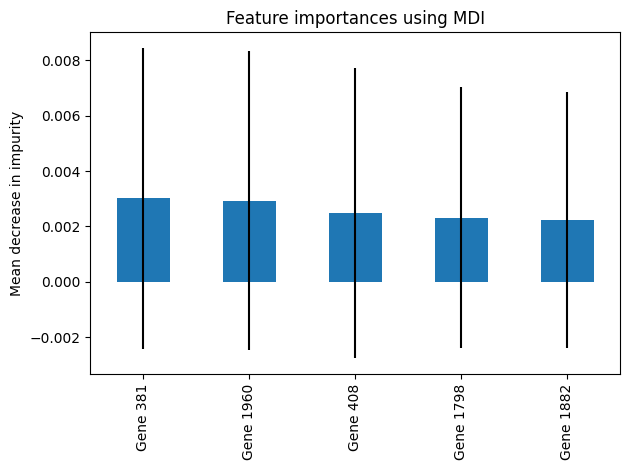

In [43]:
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)
std = np.sort(std)[::-1][:5] # Keep 5 most important features
forest_importances = pd.Series(importances, index=features.columns)
forest_importances = forest_importances.sort_values(ascending=False)[:5] # Keep 5 most important features

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### How these top 5 features are distributed per class

Sources:
- https://seaborn.pydata.org/generated/seaborn.displot.html#seaborn.displot
- https://seaborn.pydata.org/generated/seaborn.FacetGrid.html
- https://pandas.pydata.org/docs/user_guide/merging.html

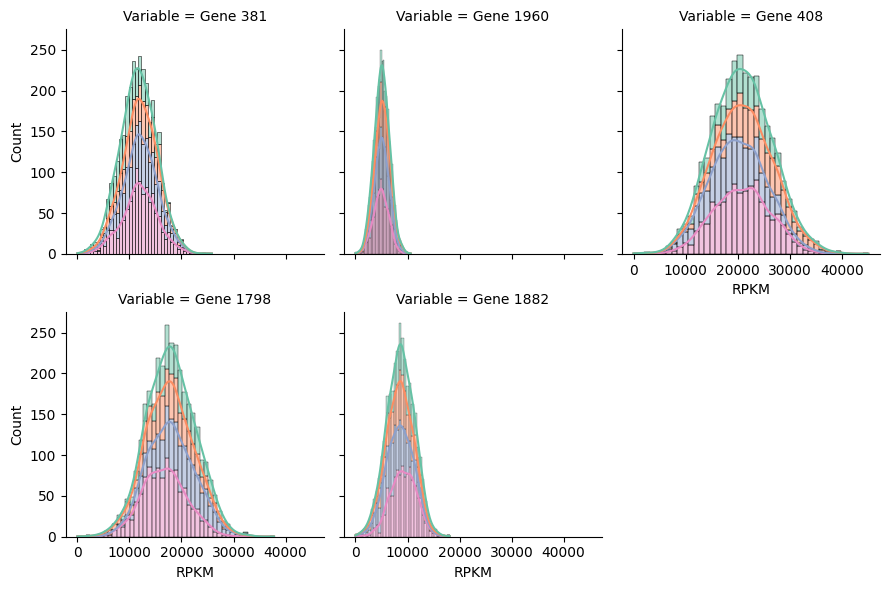

In [44]:
data = features[forest_importances.index] # Filter for most important features
data = pd.concat((data, labels), axis=1) # add labels as a column
data_long = data.melt(id_vars=['Outcome'] ,var_name='Variable', value_name='RPKM') # format data to long format, RPKM =Reads Per Kilobase Mapped

graph = sns.FacetGrid(data_long, col='Variable', col_wrap=3, )
graph.map_dataframe(sns.histplot, x ='RPKM', hue='Outcome', multiple='stack', kde=True, palette='Set2')
plt.show()

# 10 Neural network
Finally, I want you to train a simple feedforward dense/fully-connected neural network on this data. Use ReLU activation functions, and 3 hidden layers with 30, 20, and 10 neurons, and 4 output neurons for the classification (with a softmax activation). Do like we did before: define a function to make your neural net in Keras, make a scikit-learn object out of it, and train it with cross-validation. Don’t perform hyperparameter optimalisation for the neural network here. That could become very time-consuming. Scale the data, but rather than imputing nans just set them all to -1. 

In [45]:
#function to build model
def build_neural_net(input_shape=(2000,), hiddenLayerOne=30, hiddenLayerTwo=20, hiddenLayerThree=10, learnRate=0.01):
    # initialize a sequential model and add layer to flatten the input data
    model = Sequential()

    model.add(Input(input_shape))
    model.add(Dense(hiddenLayerOne, activation="relu"))
    model.add(Dropout(0.3))
              
    model.add(Dense(hiddenLayerTwo, activation="relu"))
    model.add(Dropout(0.3))

    model.add(Dense(hiddenLayerThree, activation="relu"))
    model.add(Dropout(0.3))
              
    # add a softmax layer on top
    model.add(Dense(4, activation="softmax"))
              
    # compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learnRate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"])
              
    # return compiled model
    return model

model = KerasClassifier(model=build_neural_net, verbose=0)

pipe = Pipeline([
    ('normilization', StandardScaler()), 
    ('model', model)
])

# Convert dataframe to numpy array
X_train_array = np.array(X_train)
y_train_array = np.array(y_train)
X_val_array = np.array(X_val)
y_val_array = np.array(y_val)

# Replace Nan values with -1
X_train_array = np.where(np.isnan(X_train_array), -1, X_train_array)
X_val_array = np.where(np.isnan(X_val_array), -1, X_val_array)

# Fit and measure performance
pipe.fit(X_train_array, y_train_array)
scoring = 'accuracy'
score = cross_validate(pipe, X_val_array, y_val_array, cv=5, scoring=scoring)

print(f'Mean validation {scoring} across folds: {round(np.mean(score["test_score"]), 2)}')

Mean validation accuracy across folds: 0.28


In [46]:
# Predict on test set
score = pipe.score(np.array(test_features), np.array(test_labels).flatten())
print(f'{scoring} on test set: {round(score, 2)}')

accuracy on test set: 0.36


# Final classifier
we've chosen to use a random forest as our final classifier because there are many features in our dataset and the Random forest classifier tends to handle those better. 
we'll improve on our earlier trial with some hyperparameter optimization, since we haven't don

In [47]:
# train and validation split not needed because those splits happen through nested cross vaidation
X = X_downSampled
y = y_downSampled

In [48]:
# define the pipeline
pipe = Pipeline(steps=[
    ('impute', SimpleImputer()),
    ('random_forest', RandomForestClassifier(n_jobs=-2, random_state=global_seed, verbose=0))
])

# hyperparameter grid
param_grid = {
    'random_forest__n_estimators': [100, 250, 500],
    'random_forest__max_depth': [10, 20, 30, 40, 50],
    'random_forest__min_samples_split': [2, 5, 10],
    'random_forest__min_samples_leaf': [1, 2, 4],
    'random_forest__max_features': ['auto', 'sqrt', 'log2']
}
# param_grid = {
#     'random_forest__n_estimators': [100, 250],
#     'random_forest__max_depth': [10, 20]
# }

# nested cross-validation
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=global_seed)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=global_seed)

# Scoring
scoring = ['roc_auc_ovr','f1_macro']

# Hyperparameter optimization
grid_search = HalvingGridSearchCV(
    estimator=pipe, 
    param_grid=param_grid, 
    cv=inner_cv, 
    n_jobs=-2, 
    scoring='f1_macro',
    verbose=1
)

# Measuring performance using nested cross validation
print(f"Starting run...")
start_time = time.time()
nested_scores = cross_val_score(
    grid_search, 
    X, 
    y, 
    cv=outer_cv, 
    scoring='f1_macro', 
    n_jobs=-2,
    verbose=1
)
end_time = time.time()
elapsed_time = end_time - start_time
minutes = int(elapsed_time // 60)
seconds = elapsed_time % 60
print(f"Run done! Elapsed time: {minutes} min {seconds:.2f} sec")

print(f'Nested CV ROC AUC scores: {nested_scores}')
print(f'Mean ROC AUC score: {np.mean(nested_scores)}')

Starting run...


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


KeyboardInterrupt: 

In [ ]:
# Predict on test set
y_pred = pipe.predict(test_features)
y_prob = pipe.predict_proba(test_features)  # for roc_auc

test_scores = {
    'roc_auc_ovr': roc_auc_score(test_labels, y_prob, multi_class='ovr'),
    'f1_macro': f1_score(test_labels, y_pred, average='macro')
    'accuracy': accuracy(test_labels, y_pred)
}

for metric, value in test_scores.items():
    print(f'{metric} on test set: {round(value, 2)}')